# Практическое задание

# Оценивание семантической схожести текстов

## курс "Анализ неструктурированных данных"


### ФИО: <впишите>

-----

## Введение

В этом задании вы будете использовать векторные представления слов для выделения групп, схожих по смыслу.

### Используемые библиотеки

Для выполнения потребуются следующие библиотеки:
- [Gensim](https://radimrehurek.com/gensim/) — инструмент для решения различных задач NLP (тематическое моделирование, представление текстов, ...);
- [Numpy](http://www.numpy.org) — библиотека для векторных вычислений;
- [Pandas](https://pandas.pydata.org) - библиотека для анализа табличных данных;
- [scikit-learn](http://scikit-learn.org/stable/index.html) — библилиотека с алгоритмами классического машинного обучения;
- [matplotlib](https://matplotlib.org) - библиотека для построения графиков;

-------

## Подготовка к выполнению задания:

**ВАЖНО:** Пожалуйста, ставьте python 3.10 (или 3.9). Предоставленное окружение не работает как минимум на python 3.13

-----

In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

# Константы
DATA_DIR = 'data'
RANDOM_STATE = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Модель, генерирующая вектора слов

Для решения вам потребуются предобученная модель векторных представлений слов. 

Используйте русскоязычную [модель эмбеддингов](https://rusvectores.org/ru/models/) (Если функция ниже не работает - [прямая ссылка на скачивание](http://vectors.nlpl.eu/repository/20/213.zip)), обученную на GeoWAC - мультиязычном корпусе интернет-страниц.

In [13]:
# from utils import download_model

# download_model(data_dir=DATA_DIR)

## Часть 1. Предобученные векторные представления слов

Скачайте предобученные вектора и загрузите их с помощью функции [fasttext.FastTextKeyedVectors.load](https://radimrehurek.com/gensim/models/fasttext.html) библиотеки Gensim.

In [14]:
import gensim

wv_embeddings = gensim.models.fasttext.FastTextKeyedVectors.load(
    DATA_DIR + "/model/model.model"
)

### Как пользоваться этими векторами?

Как только вы загрузите векторные представления слов в память, убедитесь, что имеете к ним доступ. Сначала вы можете проверить, содержится ли какое-то слово в загруженных эмбедингах:

    'слово' in wv_embeddings

В задании используется улучшенная версия Word2Vec моделей - FastText. Основное её отличие заключается в том, что модель работает с подсловами (character n-grams), а не целыми словами. Это дает несколько важных преимуществ:

1. Модель способна работать с неизвестными словами, которых не было в обучающей выборке
2. Лучше справляется со словами с опечатками
3. Эффективна для языков с богатой морфологией (включая русский)



### Проверим, корректны ли векторные представления

Чтобы предотвратить возможные ошибки во время первого этапа, можно проверить, что загруженные вектора корректны. Для этого проверьте три пункта:
1. Используя метод `.most_similar(positive=..., negative=...)`, найти слово, похожее на `женщина`, `царь` и непохожее на `мужчина`.
2. Используя метод `.doesnt_match(...)`, найти "белую ворону" в списке `['завтрак, 'обед', 'ужин', 'хлопья']`.
3. Используя метод `.most_similar_to_given(word, [...])`, найти наиболее похожее на `музыка` слово из списка `['вода', 'звук', 'рюкзак', 'мышь']`.

Прокомментируйте полученные результаты: считаете ли вы их верными и почему.

In [15]:
wv_embeddings.most_similar(positive=['женщина', 'царь'], negative=['мужчина'])

[('царица', 0.6945165991783142),
 ('государь', 0.6685225367546082),
 ('император', 0.6528248190879822),
 ('ирод', 0.638839066028595),
 ('правитель', 0.6368341445922852),
 ('султан', 0.6227053999900818),
 ('императрица', 0.62171870470047),
 ('царствование', 0.6172480583190918),
 ('царственно', 0.6162067651748657),
 ('визирь', 0.6102694869041443)]

In [16]:
wv_embeddings.doesnt_match(['завтрак', 'обед', 'ужин', 'хлопья'])

'хлопья'

In [17]:
wv_embeddings.most_similar_to_given('музыка', ['вода', 'звук', 'рюкзак', 'мышь'])

'звук'

# Часть 2: Кластеризация слов из файла

In [18]:
words = []
embeddings = []
# В строке ниже можно заменить название файла 
with open("words_small.txt", "r", encoding="utf-8") as reader:
    words = reader.read().split()[1:]
    embeddings = [wv_embeddings[word] for word in words]

# Преобразуем полученные эмбеддинги в numpy-массив и нормализуем их
embeddings = np.array(embeddings)
embeddings /= np.linalg.norm(embeddings)

In [19]:
# Кластеризуем с помощью метода их библиотеки
from sklearn.cluster import KMeans

# Здесь можно изменить количество кластеров
model = KMeans(n_clusters=30, random_state=RANDOM_STATE)
labels = model.fit_predict(embeddings) # получим метки кластеров, соответствующие эмбеддингам

Визуализация полученных результатов. 

Метод `plot_clusters_with_labels` применяет алгоритм [TSNE](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%B2%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B9_%D1%81_t-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC), который является *алгоритмом машинного обучения* для визуализации данных высокой размерности в пространстве с низкой размерностью, причем похожие объекты моделируются близко расположенными точками, а непохожие - с большой вероятностью, точками, далеко стоящими друг от друга.

Разные цвета на графике обозначают разные кластеры. 

***Может долго работать***

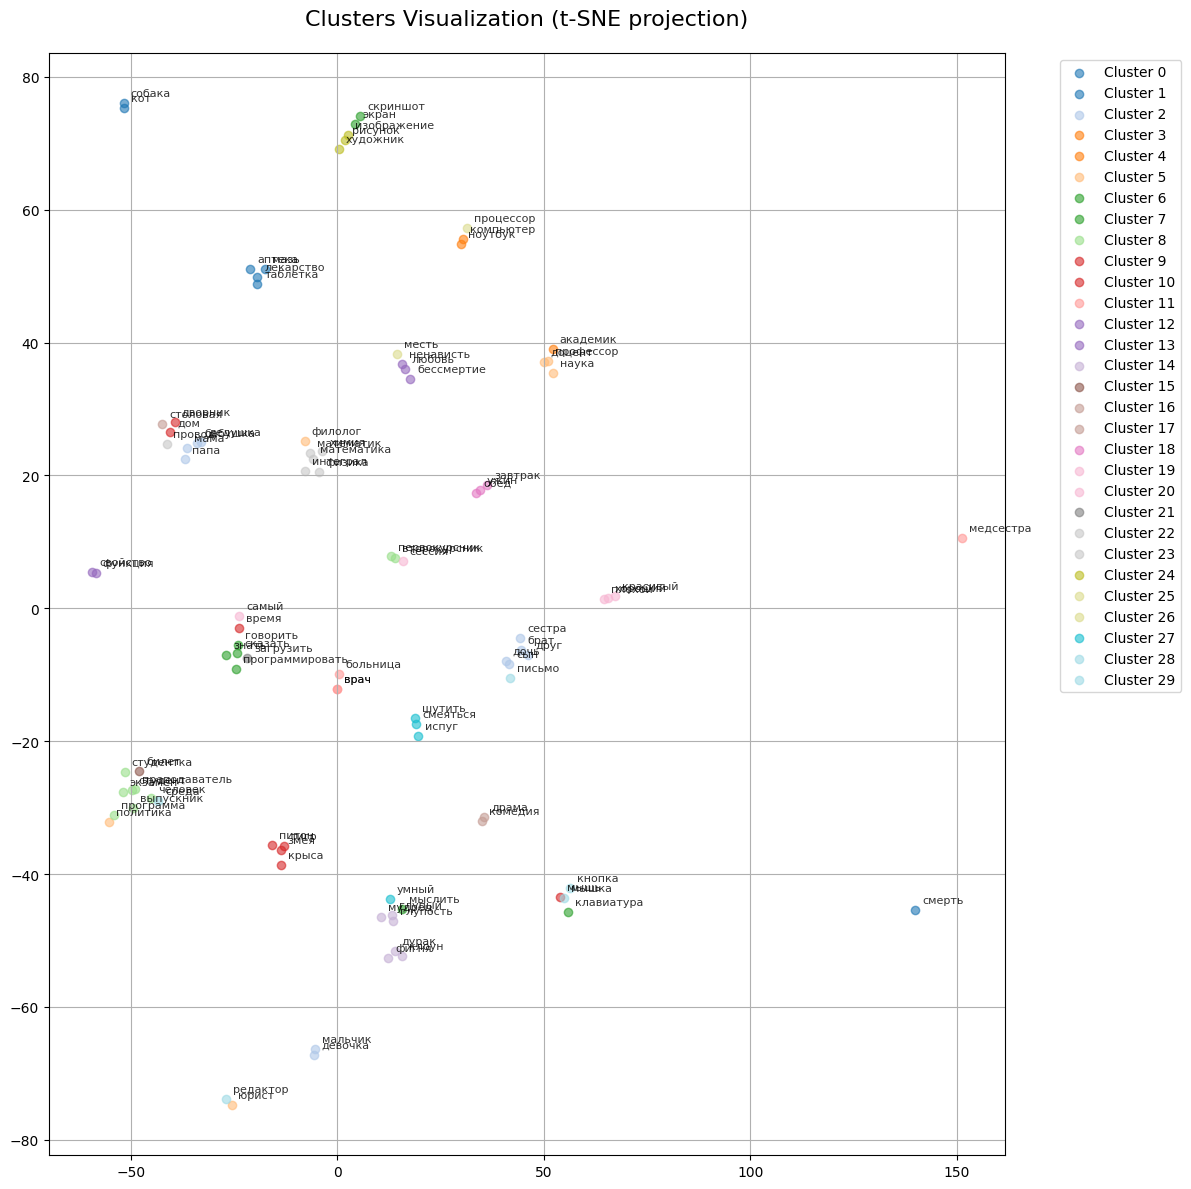

In [20]:
from utils import plot_clusters_with_labels

plot_clusters_with_labels(
    embeddings=embeddings,
    labels=labels,
    words=words,
    figsize=(12, 12), # можно менять размер рисунка (ширина и высота задаются в дюймах)
    sample_size=embeddings.shape[0] # количество точек для отображения (сейчас заданы все)
)

Полученный выше график (если запускать кластеризацию на большом файле) выглядит красиво, но абсолютно нечитаемо. 

***Идея:*** отображать на графике не все классы, а по несколько классов на график.
 -  amount_on_plot - задает желаемое количество классов для отображения на одном графике. 

Поскольку исходное количестов уникальных меток может не делиться нацело на amount_on_plot на последнем графике будут отображаться последние кластеры дополненные недостающим количеством первых кластеров. 

***Может долго работать***

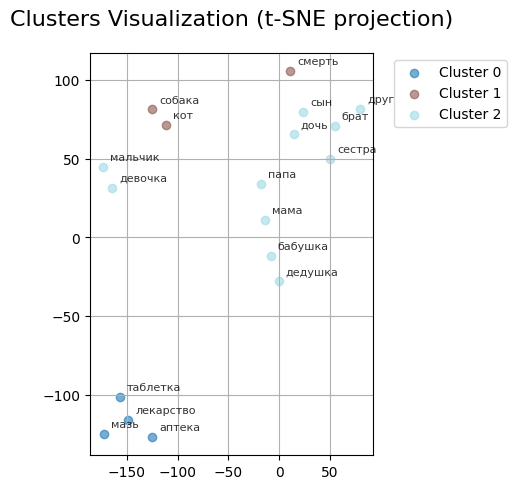

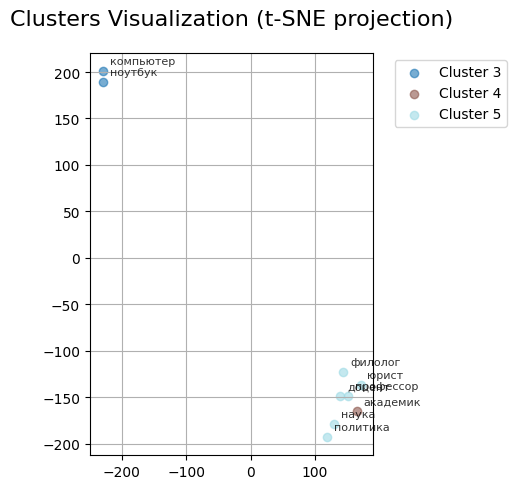

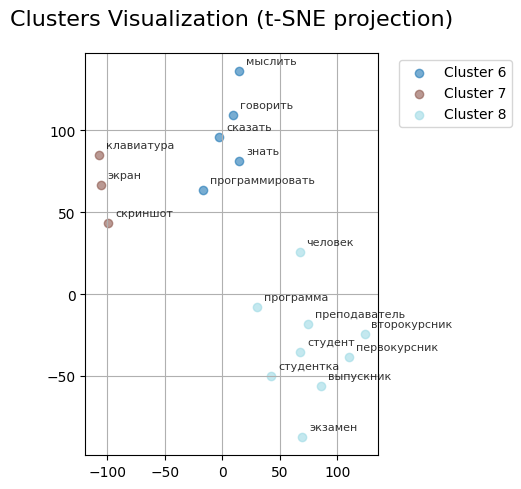

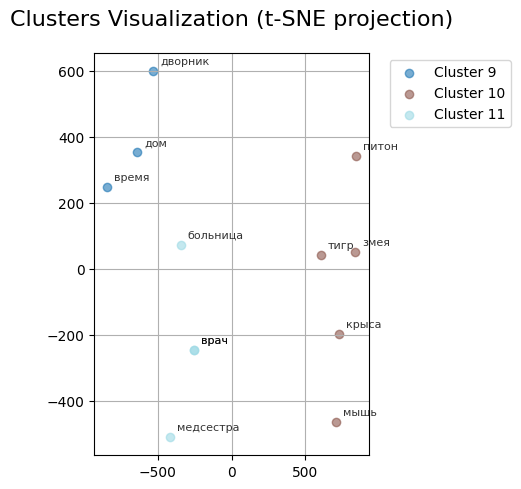

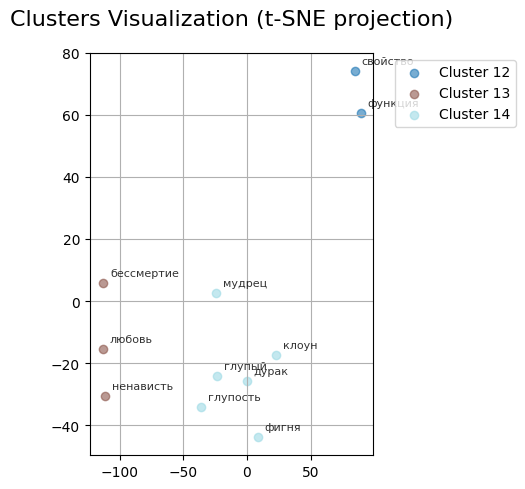

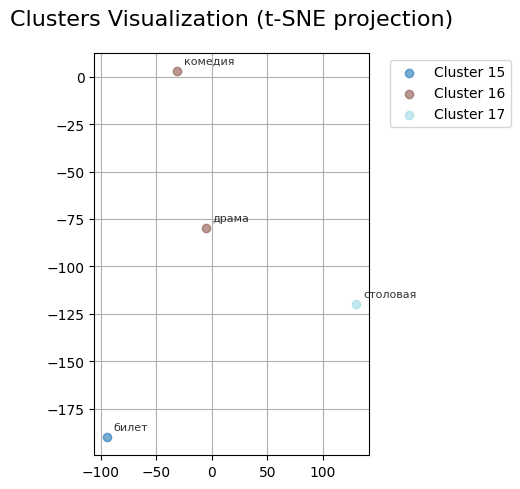

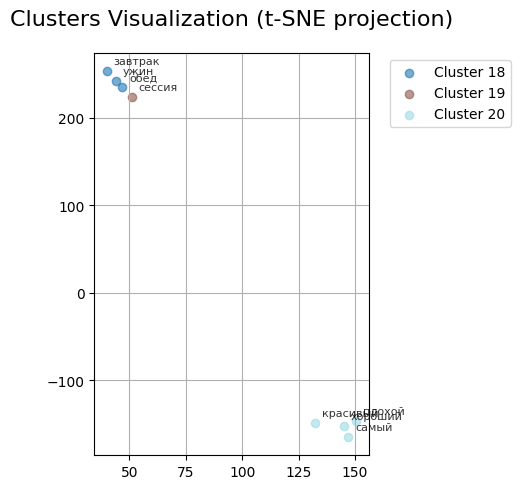

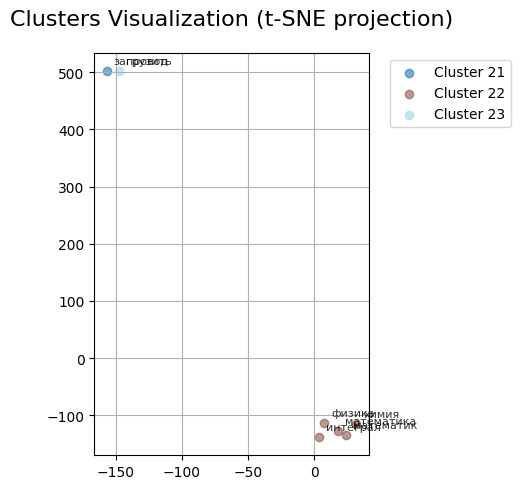

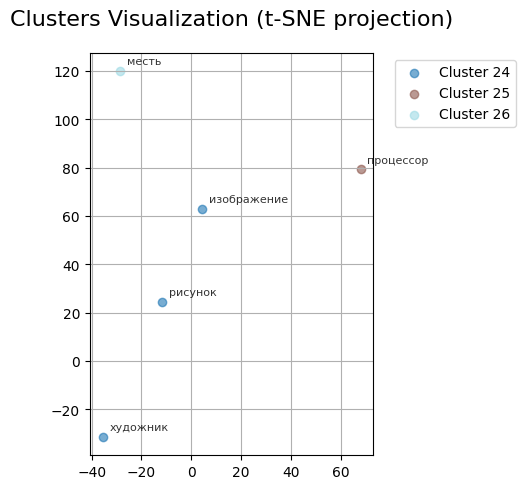

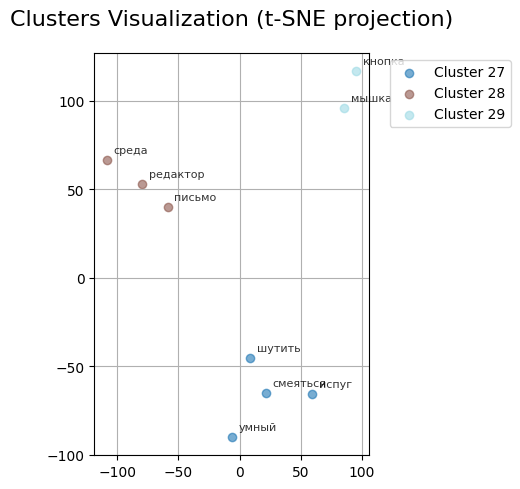

In [21]:
amount_on_plot = 3

unique_labels = list(set(labels))
i = 0
while len(unique_labels) % amount_on_plot != 0:
    unique_labels.append(unique_labels[i])
    i += 1
  
for i in range(0, len(unique_labels), amount_on_plot):
    visualizing_labels = []
    visualizing_words = []
    visualizing_emb = []

    for lab, emb, word in zip(labels, embeddings, words):
        if lab in unique_labels[i:i+amount_on_plot]:
            visualizing_labels.append(lab)
            visualizing_words.append(word)
            visualizing_emb.append(emb)

    
    visualizing_emb = np.array(visualizing_emb)
    plot_clusters_with_labels(
        embeddings=visualizing_emb,
        labels=visualizing_labels,
        words=visualizing_words,
        figsize=(5, 5),
        sample_size=visualizing_emb.shape[0]
    )